<a href="https://colab.research.google.com/github/jmeier1963/NLP-with-Python/blob/master/tweetarchive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of tweet archive
As the Twitter API only maintains a 7-day search index one needs to build an archive of tweets manually.
Most of the code is adapted from https://github.com/Jefferson-Henrique/GetOldTweets-python/

In [36]:
!pip install pyquery
!pip install selenium
!pip install textblob-de

     |████████████████████████████████| 471kB 2.8MB/s 


In [7]:
import urllib.request, urllib.parse, urllib.error,urllib.request,urllib.error,urllib.parse,json,re,datetime,sys,http.cookiejar
from pyquery import PyQuery
import pandas as pd
import time
import datetime

import re
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords

import heapq
import numpy as np
from os import path
from PIL import Image

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
# settings
# search parameters German or English
q = '#Suffizienz'
q1 = q[1:].lower()
q2 = q1.capitalize()

since = "2010-01-01"
until = "2020-6-30"

bins = 20
    
stop_ger = nltk.corpus.stopwords.words('german')
stop_eng = nltk.corpus.stopwords.words('english')
customstopwords = [q1, q2, 'dlvr', 'az', 'su', 'html', 'twitter', 'aw', 'com', 'pic', 'bit', 'via', 'https']

## Building an archive of tweets

In [9]:
class TweetCriteria:

	def __init__(self):
		self.maxTweets = 0

	def setUsername(self, username):
		self.username = username
		return self

	def setSince(self, since):
		self.since = since
		return self

	def setUntil(self, until):
		self.until = until
		return self

	def setQuerySearch(self, querySearch):
		self.querySearch = querySearch
		return self

	def setMaxTweets(self, maxTweets):
		self.maxTweets = maxTweets
		return self

	def setLang(self, Lang):
		self.lang = Lang
		return self

	def setTopTweets(self, topTweets):
 		self.topTweets = topTweets
 		return self
    
class Tweet:
	
	def __init__(self):
		pass

def getTweets(tweetCriteria, receiveBuffer=None, bufferLength=100, proxy=None):
    refreshCursor = ''

    results = []
    resultsAux = []
    cookieJar = http.cookiejar.CookieJar()

    active = True

    while active:
        json = getJsonReponse(tweetCriteria, refreshCursor, cookieJar, proxy)
        if len(json['items_html'].strip()) == 0:
            break

        refreshCursor = json['min_position']
        scrapedTweets = PyQuery(json['items_html'])
        #Remove incomplete tweets withheld by Twitter Guidelines
        scrapedTweets.remove('div.withheld-tweet')
        tweets = scrapedTweets('div.js-stream-tweet')

        if len(tweets) == 0:
            break
        
        for tweetHTML in tweets:
            tweetPQ = PyQuery(tweetHTML)            
            
            # usernameTweet = tweetPQ("span.username.js-action-profile-name b").text()  does not work
            usernames = tweetPQ("span.username").text()   # gets multiple usernames
            usernameTweet = re.sub("[^\w]", " ",  usernames).split()[0]   # pick first name in list   
            s = re.sub(r"\s+", " ", tweetPQ("p.js-tweet-text").text())
            txt = s.replace('# ', '#').replace('@ ', '@')   
            retweets = int(tweetPQ("span.ProfileTweet-action--retweet span.ProfileTweet-actionCount").attr("data-tweet-stat-count").replace(",", ""))
            favorites = int(tweetPQ("span.ProfileTweet-action--favorite span.ProfileTweet-actionCount").attr("data-tweet-stat-count").replace(",", ""))
            dateSec = int(tweetPQ("small.time span.js-short-timestamp").attr("data-time"))
            id = tweetPQ.attr("data-tweet-id")
            permalink = tweetPQ.attr("data-permalink-path")
            user_id = int(tweetPQ("a.js-user-profile-link").attr("data-user-id"))      
            geo = ''
            geoSpan = tweetPQ('span.Tweet-geo')
            if len(geoSpan) > 0:
                geo = geoSpan.attr('title')           
            urls = []
            for link in tweetPQ("a"):
                try:
                    urls.append((link.attrib["data-expanded-url"]))
                except KeyError:
                    pass
            
            tweet = {}         
            tweet["id"] = id
            tweet["permalink"] = 'https://twitter.com' + permalink
            tweet["username"] = usernameTweet
            tweet["text"] = txt
            tweet["date"] = datetime.datetime.fromtimestamp(dateSec)
            tweet["formatted_date"] = datetime.datetime.fromtimestamp(dateSec).strftime("%a %b %d %X +0000 %Y")
            tweet["retweets"] = retweets
            tweet["favorites"] = favorites
            tweet["mentions"] = " ".join(re.compile('(@\\w*)').findall(txt))
            tweet["hashtags"] = " ".join(re.compile('(#\\w*)').findall(txt))
            tweet["geo"] = geo
            tweet["urls"] = ",".join(urls)
            tweet["author_id"] = user_id
            
            results.append(tweet)
            resultsAux.append(tweet)
            
            if receiveBuffer and len(resultsAux) >= bufferLength:
                receiveBuffer(resultsAux)
                resultsAux = []
            
            if tweetCriteria.maxTweets > 0 and len(results) >= tweetCriteria.maxTweets:
                active = False
                break

    if receiveBuffer and len(resultsAux) > 0:
        receiveBuffer(resultsAux)

    return results

def getJsonReponse(tweetCriteria, refreshCursor, cookieJar, proxy):
    url = "https://twitter.com/i/search/timeline?f=tweets&q=%s&src=typd&%smax_position=%s"
    
    urlGetData = ''
    if hasattr(tweetCriteria, 'username'):
        urlGetData += ' from:' + tweetCriteria.username
    if hasattr(tweetCriteria, 'since'):
        urlGetData += ' since:' + tweetCriteria.since
    if hasattr(tweetCriteria, 'until'):
        urlGetData += ' until:' + tweetCriteria.until
    if hasattr(tweetCriteria, 'querySearch'):
        urlGetData += ' ' + tweetCriteria.querySearch
    if hasattr(tweetCriteria, 'lang'):
        urlLang = 'lang=' + tweetCriteria.lang + '&'
    else:
        urlLang = ''
    url = url % (urllib.parse.quote(urlGetData), urlLang, refreshCursor)
    #print(url)

    headers = [
        ('Host', "twitter.com"),
        ('User-Agent', "Mozilla/5.0 (Windows NT 6.1; Win64; x64)"),
        ('Accept', "application/json, text/javascript, */*; q=0.01"),
        ('Accept-Language', "de,en-US;q=0.7,en;q=0.3"),
        ('X-Requested-With', "XMLHttpRequest"),
        ('Referer', url),
        ('Connection', "keep-alive")
        ]

    if proxy:
        opener = urllib.request.build_opener(urllib.request.ProxyHandler({'http': proxy, 'https': proxy}), urllib.request.HTTPCookieProcessor(cookieJar))
    else:
        opener = urllib.request.build_opener(urllib.request.HTTPCookieProcessor(cookieJar))
    opener.addheaders = headers

    try:
        response = opener.open(url)
        jsonResponse = response.read()
    except:
        #print("Twitter weird response. Try to see on browser: ", url)
        print("Twitter weird response. Try to see on browser: https://twitter.com/search?q=%s&src=typd" % urllib.parse.quote(urlGetData))
        print("Unexpected error:", sys.exc_info()[0])
        sys.exit()
        return

    dataJson = json.loads(jsonResponse.decode())

    return dataJson

In [10]:
def tweet_interval(q, since, until):
    tweetCriteria = TweetCriteria().setQuerySearch(q).setSince(since).setUntil(until).setMaxTweets(100)
    tweets = getTweets(tweetCriteria)
    if len(tweets) == 100:
        s = time.mktime(datetime.datetime.strptime(since, "%Y-%m-%d").timetuple())
        u = time.mktime(datetime.datetime.strptime(until, "%Y-%m-%d").timetuple())
        d = datetime.datetime.utcfromtimestamp((s + u)/2)
        middle_time = d.strftime("%Y-%m-%d")
        print (middle_time)
        tweets1 = tweet_interval(q, since, middle_time)
        tweets2 = tweet_interval(q, middle_time, until)
        if (len(tweets1)+len(tweets2) == 100):
            return tweets
        else: 
            return tweets1 + tweets2
    else:
        return tweets

    
s = time.mktime(datetime.datetime.strptime(since, "%Y-%m-%d").timetuple())
u = time.mktime(datetime.datetime.strptime(until, "%Y-%m-%d").timetuple())

bin_size = (u-s)/bins
bin_counter = 1

while s < u:
    new_since = datetime.datetime.utcfromtimestamp(s).strftime("%Y-%m-%d")
    if (s + bin_size < u):
        new_until = datetime.datetime.utcfromtimestamp(s + bin_size).strftime("%Y-%m-%d")
    else:
        new_until = datetime.datetime.utcfromtimestamp(u).strftime("%Y-%m-%d")
    print("Gathering tweets from ", new_since, "to", new_until)
    tweets = tweet_interval(q, new_since, new_until)
    pd.DataFrame(tweets).to_pickle(q+"_tweets_bin"+str(bin_counter)+".pkl")
    bin_counter += 1
    s += bin_size

Gathering tweets from  2010-01-01 to 2010-07-11
Gathering tweets from  2010-07-11 to 2011-01-19
Gathering tweets from  2011-01-19 to 2011-07-29
Gathering tweets from  2011-07-29 to 2012-02-06
Gathering tweets from  2012-02-06 to 2012-08-16
Gathering tweets from  2012-08-16 to 2013-02-23
Gathering tweets from  2013-02-23 to 2013-09-03
Gathering tweets from  2013-09-03 to 2014-03-14
Gathering tweets from  2014-03-14 to 2014-09-21
Gathering tweets from  2014-09-21 to 2015-04-01
2014-12-26
Gathering tweets from  2015-04-01 to 2015-10-10
2015-07-06
Gathering tweets from  2015-10-10 to 2016-04-18
Gathering tweets from  2016-04-18 to 2016-10-27
Gathering tweets from  2016-10-27 to 2017-05-07
2017-01-31
Gathering tweets from  2017-05-07 to 2017-11-14
Gathering tweets from  2017-11-14 to 2018-05-25
2018-02-18
Gathering tweets from  2018-05-25 to 2018-12-03
2018-08-29
2018-10-16
Gathering tweets from  2018-12-03 to 2019-06-12
2019-03-08
2019-04-25
2019-05-19
Gathering tweets from  2019-06-12 to 

In [11]:
import os

cwd = os.getcwd()
filelist = [ f for f in os.listdir(cwd) if f.startswith(q+"_tweets_bin") ]

df = pd.DataFrame()
df_list = []
for f in filelist:
    df_list.append(pd.read_pickle(f))

df = pd.concat(df_list, ignore_index= True)
df.to_pickle(q + "_tweets_" + since + "_to_" + until +".pkl")

In [12]:
import os

cwd = os.getcwd()
filelist = [ f for f in os.listdir(cwd) if f.startswith(q+"_tweets_bin") ]
for f in filelist:                                                              
    os.remove(os.path.join(cwd, f))

## Tweets per month containing search term

In [13]:
df["tweets"]=df["id"].apply(lambda x: 1)

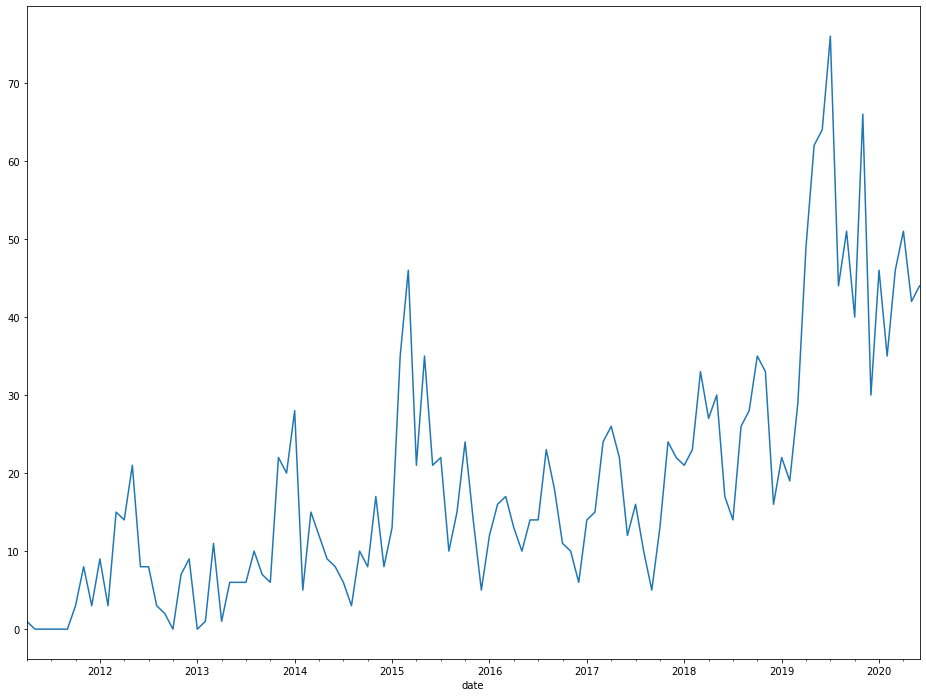

In [14]:
df = df.set_index(pd.DatetimeIndex(df['date']))
df.groupby(pd.Grouper(freq='M')).sum()["tweets"].plot(figsize=(16,12))
plt.savefig(q+"-tweetspermonth.png")

## Frequency distribution Tweets per user

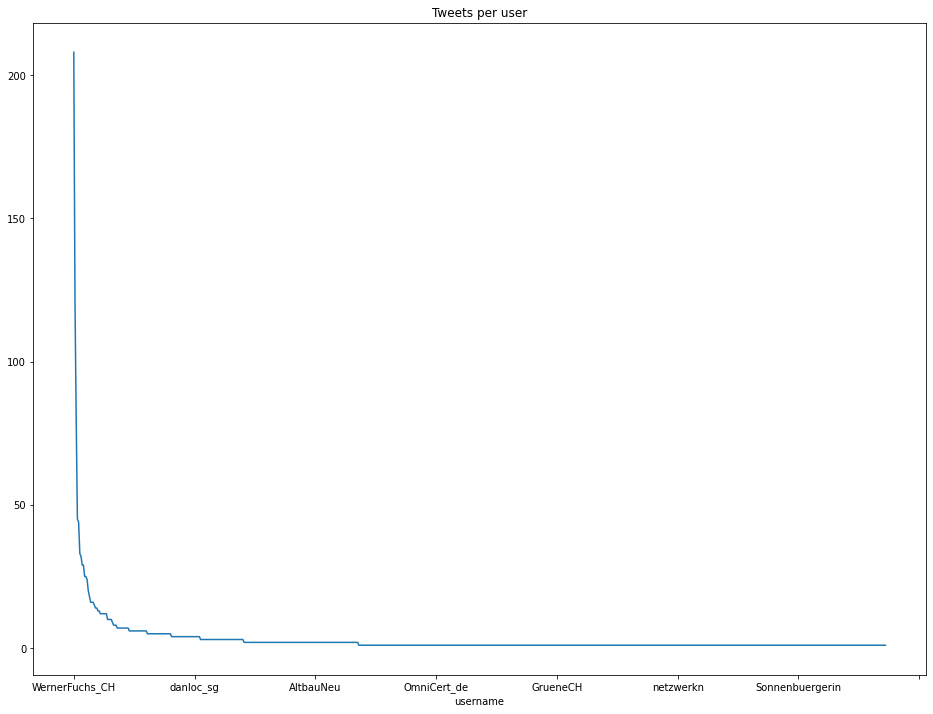

In [15]:
import matplotlib.pyplot as plt

df.groupby("username")["id"].count().sort_values(ascending=False).plot(figsize=(16,12),title="Tweets per user")
plt.savefig(q+"-handles.png")

In [16]:
df.groupby("username")["id"].count().sort_values(ascending=False)[0:30]

username
WernerFuchs_CH     208
Sabeth_Faber       121
kultur_nachhalt     80
sharely_ch          45
heckm42             44
suehlmann_faul      33
WWF_Schweiz         32
eco_ch_forum        29
Schnecken_Post      29
olivergraf          25
nhbot               25
umweltstifter       24
ioew_de             20
adfc_FL             18
mvb_energy          16
city2livein         16
SustDigi            16
news_rapha          15
twp59               14
gurkenblut          14
andrereichel        13
BeatGuggisberg      13
MarenIngrid         12
zukunftswerk        12
NHKodex             12
fuphil              12
Degrowth_deuts      12
Daniel7Sieben       12
bund_d              10
JanVonKorte         10
Name: id, dtype: int64

## Network of links between users (i.e. mentions)

In [20]:
import networkx

network = networkx.Graph()
c1 = 0
c2 = 0

for index, status in df.iterrows():
    if status["username"] not in network.nodes:
        network.add_node(status["username"], name=status["username"])
    
    for username in status['mentions'].split():
        shortname = username[1:]     # strip @
        if shortname not in network.nodes:
            network.add_node(shortname, name=shortname)
  
        if (status["username"], shortname) in network.edges:
            network[status["username"]][shortname]['weight'] +=1
            c1 += 1
        else:
            network.add_edge(status["username"], shortname, weight=1.0)
            c2 += 1
            
print(network.number_of_nodes(), "Twitterusers in Tweets where", q, "is mentioned.")
print(c2+c1, "cross-references among those users with", c1, "unique edges.")

networkx.write_gml(network, q+".gml")

1193 Twitterusers in Tweets where #Suffizienz is mentioned.
1077 cross-references among those users with 143 unique edges.


In [27]:
from bokeh.models import ColumnDataSource
from bokeh.io import output_notebook
from bokeh.models import HoverTool
from bokeh.plotting import show, figure
from bokeh.io import export_png
from math import sqrt

output_notebook()

network = networkx.read_gml(q+'.gml')

layout = networkx.spring_layout(network, k=1.1/sqrt(network.number_of_nodes()), iterations=100)
# https://en.wikipedia.org/wiki/Force-directed_graph_drawing
nodes, nodes_coordinates = zip(*sorted(layout.items()))
nodes_xs, nodes_ys = list(zip(*nodes_coordinates))
nodes_source = ColumnDataSource(dict(x=nodes_xs, y=nodes_ys, name=nodes))

hover = HoverTool(tooltips=[('name', '@name'), ('id', '$index')])
plot = figure(plot_width=1200, plot_height=800, tools=['tap', hover, 'box_zoom', 'reset'])
r_circles = plot.circle('x', 'y', source=nodes_source, size=10, color='blue', level = 'overlay')

def get_edges_specs(_network, _layout):
    d = dict(xs=[], ys=[], alphas=[])
    weights = [d['weight'] for u, v, d in _network.edges(data=True)]
    max_weight = max(weights)
    calc_alpha = lambda h: 0.1 + 0.6 * (h / max_weight)

    # example: { ..., ('user47', 'da_bjoerni', {'weight': 3}), ... }
    for u, v, data in _network.edges(data=True):
        d['xs'].append([_layout[u][0], _layout[v][0]])
        d['ys'].append([_layout[u][1], _layout[v][1]])
        d['alphas'].append(calc_alpha(data['weight']))
    return d

lines_source = ColumnDataSource(get_edges_specs(network, layout))
r_lines = plot.multi_line('xs', 'ys', line_width=1.5, alpha='alphas', color='navy', source=lines_source)

centrality = networkx.algorithms.centrality.betweenness_centrality(network)
# first element are nodes again
_, nodes_centrality = zip(*sorted(centrality.items()))
max_centrality = max(nodes_centrality)

nodes_source.add([7 + 10 * t / max_centrality for t in nodes_centrality], 'centrality')

r_circles.glyph.size = 'centrality'

import community # python-louvain
partition = community.best_partition(network)
p_, nodes_community = zip(*sorted(partition.items()))
nodes_source.add(nodes_community, 'community')
community_colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628', '#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc','#e5d8bd','#fddaec','#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']
nodes_source.add([community_colors[t % len(community_colors)] for t in nodes_community], 'community_color')

r_circles.glyph.fill_color = 'community_color'

# export_png(plot, filename=q+"-network.png")
show(plot)

## Frequency distribution key terms

In [28]:
def clean_text(text):
    '''Clean the text with special characters, extra spaces etc..'''
    clean_abstract = re.sub(r'\d',' ',text)
    clean_abstract = re.sub(r'\W', ' ',clean_abstract)    
    clean_abstract = re.sub(r'\s+', ' ',clean_abstract)
    clean_abstract = re.sub(r'\[[0-9]*\]',' ', clean_abstract)
    return clean_abstract

rawtext = " ".join(df["text"]).lower()
rawtext = clean_text(rawtext)
tokens = []
sentences = []
for txt in rawtext.split():
    tokens.extend([t.lower().strip("\':,.!?") for t in txt.split()])

hashtags = [w for w in tokens if w.startswith('#')]
mentions = [w for w in tokens if w.startswith('@')]
links = [w for w in tokens if w.startswith('http') or w.startswith('www')]
filtered_tokens = [w for w in tokens \
                   if not w in stop_eng \
                   and not w in stop_ger \
                   and not w in customstopwords \
                   and w.isalpha() \
                   and not len(w)<3 \
                   and not w in hashtags \
                   and not w in links \
                   and not w in mentions]
filtered_keywords = " ".join(filtered_tokens)

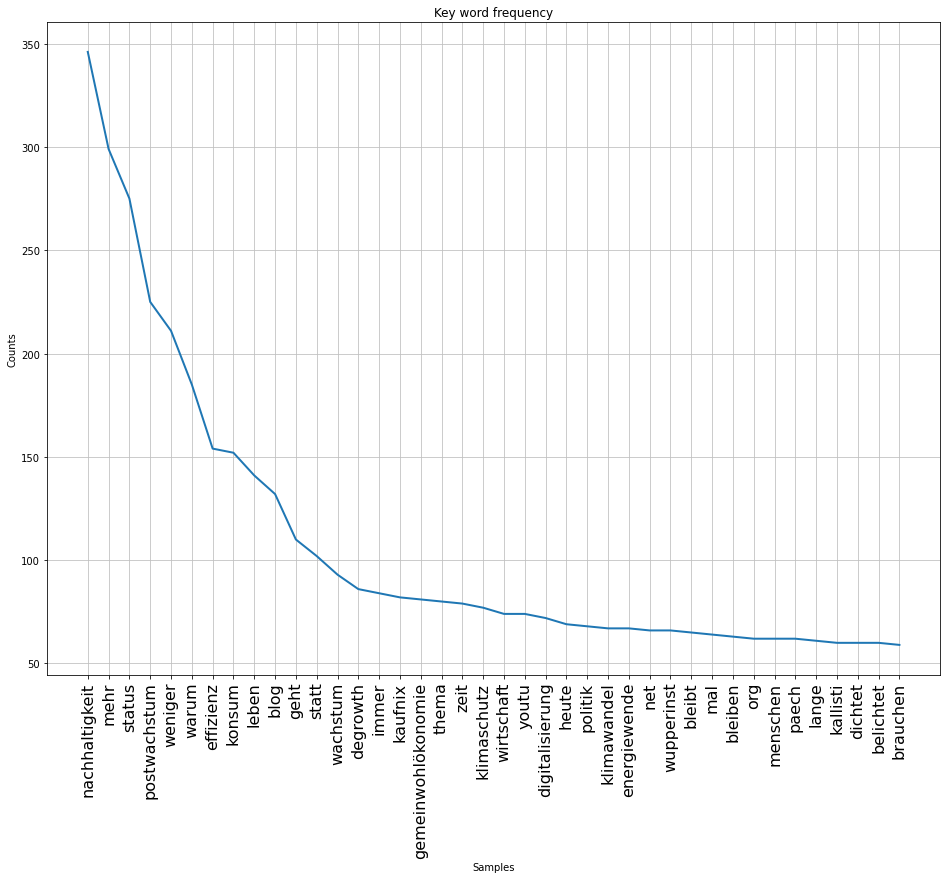

<Figure size 432x288 with 0 Axes>

In [29]:
freq_dist = nltk.FreqDist(filtered_tokens)
plt.figure(figsize=(16,12))
plt.xticks(size=16)
plt.title("Key word frequency")
freq_dist.plot(40)
plt.savefig(q+"-keyterms.png")

In [30]:
def wordcloud(text, filename):
    '''Word cloud'''
    wordcloud = WordCloud(max_font_size=1000, max_words=50, background_color="white").generate(str(text))
    plt.figure(figsize=(16,12))
    plt.imshow(wordcloud, interpolation= 'bilinear')
    plt.axis("off")
    plt.savefig(filename+".png")
    plt.show()

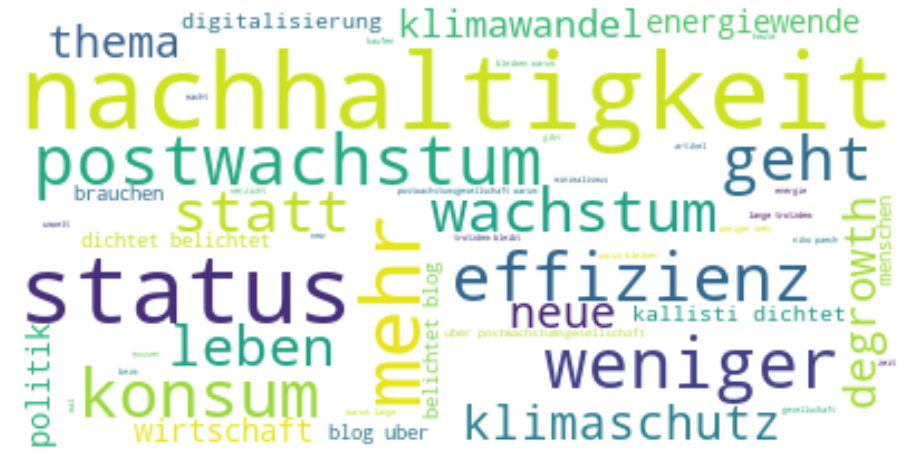

In [31]:
wordcloud(filtered_keywords,q+"wc_keyterms")

## Frequency distribution Hashtags

In [32]:
from collections import Counter

ListHashtags = " ".join(df["hashtags"]).lower().split()

a = dict(Counter(ListHashtags))

sorted(a, key=a.get, reverse=True)[:50]
# for w in sorted(a, key=a.get, reverse=True): print(w, a[w])

['#suffizienz',
 '#nachhaltigkeit',
 '#postwachstum',
 '#effizienz',
 '#gemeinwohlökonomie',
 '#degrowth',
 '#konsum',
 '#digitalisierung',
 '#klimaschutz',
 '#konvivialismus',
 '#klimawandel',
 '#energiewende',
 '#kaufnix',
 '#wachstum',
 '#kapitalismus',
 '#minimalismus',
 '#deutscheumweltstiftung',
 '#cohousing',
 '#klimakrise',
 '#enkongress',
 '#verkehrswende',
 '#konsistenz',
 '#hoffnung_durchhandeln',
 '#subsistenz',
 '#transformation',
 '#postwachstumsökonomie',
 '#suv',
 '#solawi',
 '#energieeffizienz',
 '#fridaysforfuture',
 '#soziokratie',
 '#bge',
 '#energie',
 '#kreislaufwirtschaft',
 '#wohnen',
 '#sustainability',
 '#mobilität',
 '#solar',
 '#rebound',
 '#nachhaltig',
 '#nachhaltigkeithttps',
 '#glück',
 '#wenigeristmehr',
 '#flensburg',
 '#umwelt',
 '#lessismore',
 '#fahrrad',
 '#bauen',
 '#klima',
 '#ressourcen']

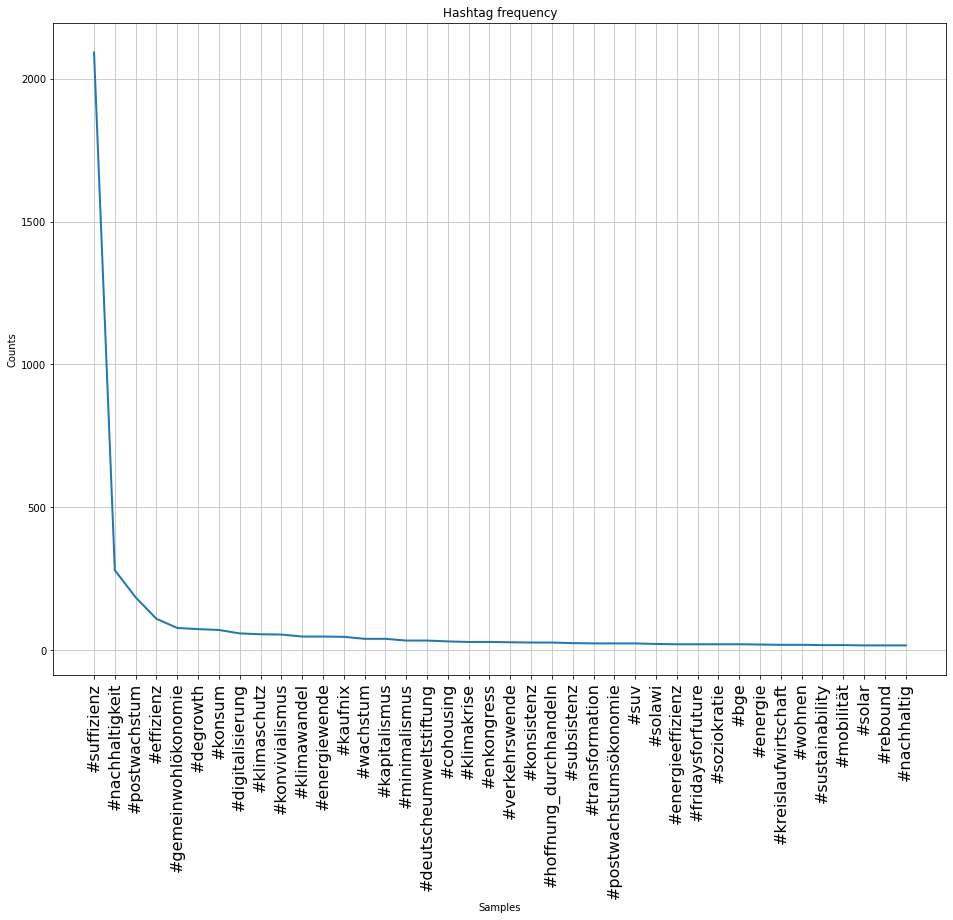

<Figure size 432x288 with 0 Axes>

In [33]:
freq_dist = nltk.FreqDist(list(filter(lambda a: a != q1, ListHashtags)))
plt.figure(figsize=(16,12))
plt.xticks(size=16)
plt.title("Hashtag frequency")
freq_dist.plot(40)
plt.savefig(q+"-hashtagfrequency.png")

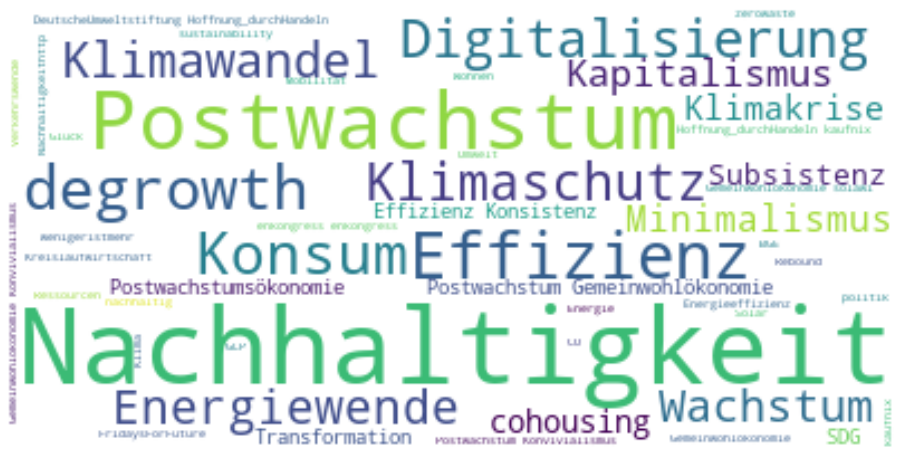

In [34]:
# Wordcloud Hashtags without #
s = " ".join(df["hashtags"])
c = clean_text(s)
c = c.replace(q1, "")
c = c.replace(q2, "")
wordcloud(c, q+"wc_hashtags")

## Sentiment analysis

In [37]:
from textblob_de import TextBlobDE as TextBlob

def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

df["polarity"]=df["text"].apply(get_sentiment)

In [38]:
def get_sentiment_category(p):
    if p > 0.4: 
        return "positive" 
    elif p < -0.4: 
        return "negative" 
    else: 
        return "neutral"

df["sentiment"] = df["polarity"].apply(get_sentiment_category)

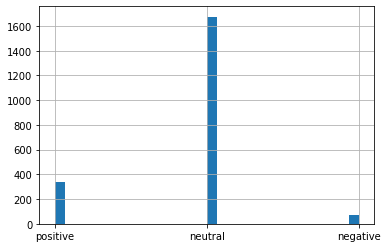

In [41]:
df["sentiment"].hist(bins=30)

In [42]:
df.set_index('date', inplace=True)
df.index = df.index.tz_localize('GMT').tz_convert('CET')
df.index.name = 'zeit'
df.index

DatetimeIndex(['2018-08-26 16:43:13+02:00', '2018-08-23 11:45:32+02:00',
               '2018-08-21 20:10:15+02:00', '2018-08-20 10:04:15+02:00',
               '2018-08-17 11:09:57+02:00', '2018-08-13 21:56:43+02:00',
               '2018-08-12 22:12:09+02:00', '2018-08-10 15:17:45+02:00',
               '2018-08-10 10:43:38+02:00', '2018-08-10 09:59:21+02:00',
               ...
               '2011-11-25 09:36:02+01:00', '2011-11-25 09:29:29+01:00',
               '2011-11-25 09:27:44+01:00', '2011-11-25 09:19:36+01:00',
               '2011-11-25 08:36:43+01:00', '2011-11-24 20:59:34+01:00',
               '2011-11-15 20:40:35+01:00', '2011-10-29 15:53:20+02:00',
               '2011-10-20 20:04:46+02:00', '2011-10-10 15:29:04+02:00'],
              dtype='datetime64[ns, CET]', name='zeit', length=2086, freq=None)

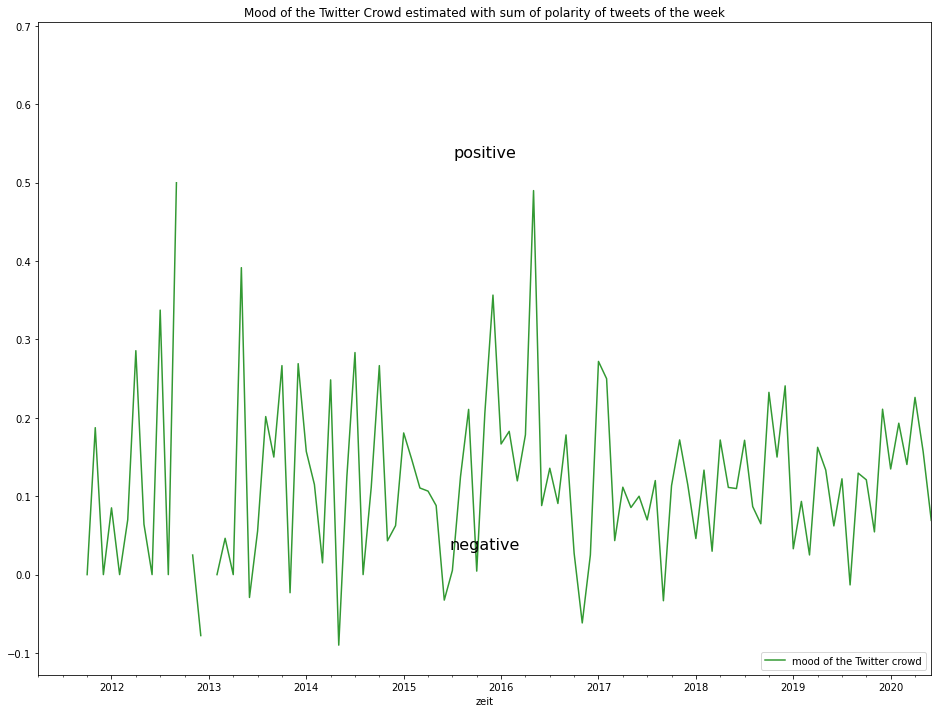

In [43]:
plt.figure(figsize=(16,12))
s = df["polarity"].resample('M').mean().plot(label='mood of the Twitter crowd', color='g', alpha=0.8)
plt.annotate('positive', xy=(0.4, 0.8),  xycoords='axes fraction',
            xytext=(0.5, 0.8), textcoords='axes fraction', size=16,
            horizontalalignment='center', verticalalignment='center')
plt.annotate('negative', xy=(0.5, 0.8),  xycoords='axes fraction',
            xytext=(0.5, 0.2), textcoords='axes fraction', size=16,
            horizontalalignment='center', verticalalignment='center')
plt.legend(loc=4)
plt.title('Mood of the Twitter Crowd estimated with sum of polarity of tweets of the week')
plt.savefig('%s_mood-crowd.png' % q, bbox_inches='tight', dpi=300)